In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils.objects import GenerationClass
from utils.config import color_maps, ycb_heights
import os
from glob import glob
from scipy import sparse
from PIL import Image
import json
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.sapien_utils import look_at
from mani_skill2.sensors.camera import CameraConfig
from mani_skill2.utils.registration import register_env
from pathlib import Path
import gymnasium as gym
from sapien.core import Pose
import numpy as np
from transforms3d.euler import euler2quat, quat2euler
from utils.config import ycb_heights, color_maps
from glob import glob
from scipy import sparse
from PIL import Image
import json
import os
# save_dir = "../final_data/"
# move_one_dir = os.path.join(save_dir, "move")
# move_cube_dir = os.path.join(move_one_dir, "cube")
# move_ycb_dir = os.path.join(move_one_dir, "ycb")
# os.makedirs(move_one_dir, exist_ok=True)
# os.makedirs(move_cube_dir, exist_ok=True)
# os.makedirs(move_ycb_dir, exist_ok=True)

In [163]:
@register_env("CustomEnv-v0", max_episode_steps=200, override=True)
class CustomEnv(PickCubeEnv):
    def _load_actors(self):
        self._add_ground(render=self.bg_name is None)
        objs = []
        builder = self._scene.create_actor_builder()
        # filepath = "/home/mkim/Nserver/mix-lab/maniskill2_dev/data/text_3d/mesh.obj"
        filepath = "/home/mkim/Nserver/mix-lab/maniskill2_dev/data/text_3d/robot/mesh.obj"
        # filepath = "/home/mkim/Nserver/mix-lab/maniskill2_dev/creation/mesh.obj"
        scale = 0.3
        scale *= self.cube_half_size / 0.01887479572529618
        builder.add_multiple_collisions_from_file(
            filename=filepath, scale=scale, density=1000
        )
        builder.add_visual_from_file(filename=filepath, scale=scale)
        self.obj = builder.build(name="hamburger")

        self.objs = objs
        self.goal_site = self._build_sphere_site(self.goal_thresh)

    def _register_cameras(self):
        pose = look_at([-1, 0, 1], [0, 0, 0])
        return CameraConfig(
            "base_camera", pose.p, pose.q, 512, 512, 1.2, 0.01, 10
        )


2024-03-27 23:27:25,815 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


In [164]:
env = gym.make("CustomEnv-v0", obs_mode="rgbd", camera_cfgs={"add_segmentation": True})

[2024-03-27 23:27:28.332] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


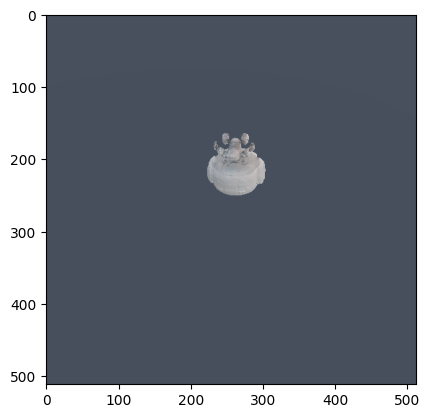

In [176]:
obs, _ =env.reset()
env.unwrapped.get_articulations()[0].set_pose(Pose([0, 0, -2], [1, 0, 0, 0]))
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))

img = obs['image']["base_camera"]["rgb"]
mask = obs['image']["base_camera"]["Segmentation"][..., :3].copy()
mask[mask != env.obj.id-2] = 0
mask = np.amax(mask.astype(bool), axis=2)

img[mask] += 50
img = np.clip(img, 0, 255)

plt.imshow(img)

In [50]:
np.unique(mask)

array([0., 1.])

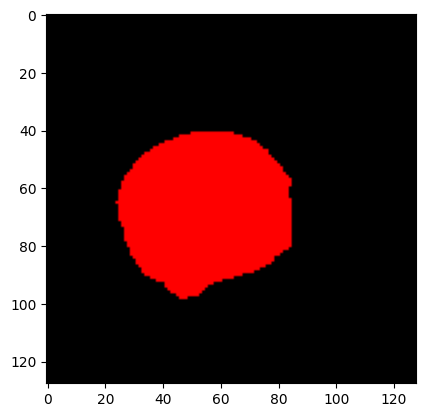

In [51]:
plt.imshow(mask)

In [9]:
env.obj.id

/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.obj to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.obj` for environment variables or `env.get_wrapper_attr('obj')` that will search the reminding wrappers.
  logger.warn(


15

In [7]:
np.unique(mask)

array([ 0, 12, 13, 14, 15], dtype=uint32)

In [8]:
env.get_actors()

/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_actors to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_actors` for environment variables or `env.get_wrapper_attr('get_actors')` that will search the reminding wrappers.
  logger.warn(


[Actor(name="ground", id="14"),
 Actor(name="hamburger", id="15"),
 Actor(name="goal_site", id="16")]

In [2]:
model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))
gen = GenerationClass(model_paths)
data_dir = "../final_data/one_cube"
gen.init_dir(data_dir)

In [3]:
# move one object
obj_cfgs, camera_cfgs = gen.cube_configs(1)

colors = list(color_maps.keys()) # 9 colors
random_scales = np.arange(3, 7) * 2


one_obj_directions = ["forward", "backward", "right", "left"]
total_idx = 0

random_trials = 20

for color in colors:
    obj_cfgs = [{
        "name": f"{color}_cube",
        "scale": np.random.choice(random_scales),
        "color": color_maps[color],
        "color_name": color,
        "static": True,
    }]

    env = gen.get_env(obj_cfgs, camera_cfgs)

    for idx in range(20):
        gen.initialize_random_positions()
        obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
        initial_img = obs['image']['base_camera']['rgb']
        seg_before, object_ids = gen.get_seg_masks(obs)

        rand_idx = np.random.choice(len(env.objs))
        obj = env.objs[rand_idx]
        direction = one_obj_directions[idx % len(one_obj_directions)]

        gen.place_object_in_direction(obj, direction)

        obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
        result_img = obs['image']['base_camera']['rgb']
        seg_after, object_ids = gen.get_seg_masks(obs)


        json_data = {
            "initial_img": f"initial/{total_idx}.png",
            "result_img": f"result/{total_idx}.png",
            "initial_seg": f"initial_seg/{total_idx}.npz",
            "result_seg": f"result_seg/{total_idx}.npz",
            "obj_id": object_ids,
            "target_object": obj.name,
            "direction": direction
        }
        gen.save_json(json_data, initial_img, result_img, seg_before, seg_after)

        total_idx += 1
        print("Done", total_idx, end="\r")

/home/mkim/miniconda3/envs/mixlab/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.objs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.objs` for environment variables or `env.get_wrapper_attr('objs')` that will search the reminding wrappers.
  logger.warn(


2024-03-26 23:45:59,516 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:45:59.516] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:01,004 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:01.004] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:02,491 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:02.491] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:04,252 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:04.253] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:06,084 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:06.084] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:07,883 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:07.884] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:09,711 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:09.711] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


2024-03-26 23:46:11,545 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-03-26 23:46:11.545] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


In [ ]:
# move one object out of multiple
obj_cfgs, camera_cfgs = gen.cube_configs(1)

colors = list(color_maps.keys()) # 9 colors
random_scales = np.arange(3, 7) * 2


one_obj_directions = ["forward", "backward", "right", "left"]
total_idx = 0

random_trials = 20

for color in colors:
    obj_cfgs = [{
        "name": f"{color}_cube",
        "scale": np.random.choice(random_scales),
        "color": color_maps[color],
        "color_name": color,
        "static": True,
    }]

    env = gen.get_env(obj_cfgs, camera_cfgs)

    for idx in range(20):
        gen.initialize_random_positions()
        obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
        initial_img = obs['image']['base_camera']['rgb']
        seg_before, object_ids = gen.get_seg_masks(obs)

        rand_idx = np.random.choice(len(env.objs))
        obj = env.objs[rand_idx]
        direction = one_obj_directions[idx % len(one_obj_directions)]

        gen.place_object_in_direction(obj, direction)

        obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
        result_img = obs['image']['base_camera']['rgb']
        seg_after, object_ids = gen.get_seg_masks(obs)


        json_data = {
            "initial_img": f"initial/{total_idx}.png",
            "result_img": f"result/{total_idx}.png",
            "initial_seg": f"initial_seg/{total_idx}.npz",
            "result_seg": f"result_seg/{total_idx}.npz",
            "obj_id": object_ids,
            "target_object": obj.name,
            "direction": direction
        }
        gen.save_json(json_data, initial_img, result_img, seg_before, seg_after)

        total_idx += 1
        print("Done", total_idx, end="\r")

ValueError: Cannot take a larger sample than population when 'replace=False'

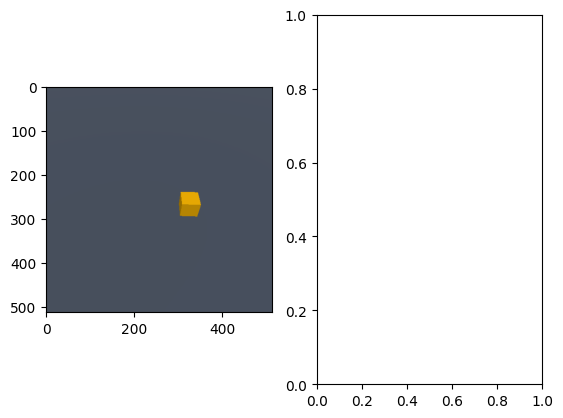

In [70]:
two_objs_directions = ["front", "behind", "right", "left", "top"]


gen.initialize_random_positions()
fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])

two_objs_direction = np.random.choice(two_objs_directions)
rand = np.random.choice(np.arange(len(obj_cfgs)), 2, replace=False)

obj1 = env.unwrapped.objs[rand[0]]
obj2 = env.unwrapped.objs[rand[1]]

gen.place_object_on_another(obj1, obj2, two_objs_direction)

obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])

if obj1.name == "cube":
    cube_1 = obj_cfgs[rand[0]]["color_name"]
    cube_2 = obj_cfgs[rand[1]]["color_name"]
    plt.title(cube_1+f"_{two_objs_direction}_{cube_2}")
else:
    plt.title(obj1.name+f"_{two_objs_direction}_{obj2.name}")
plt.show()

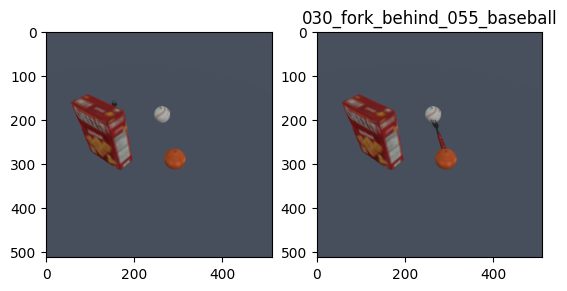

In [18]:
two_objs_directions = ["front", "behind", "right", "left", "top"]


gen.initialize_random_positions()
fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])

two_objs_direction = np.random.choice(two_objs_directions)
rand = np.random.choice(np.arange(len(obj_cfgs)), 2, replace=False)
single_rand = np.random.choice(np.arange(len(obj_cfgs)), 1)

obj1 = env.unwrapped.objs[rand[0]]
obj2 = env.unwrapped.objs[rand[1]]
obj3 = env.unwrapped.objs[single_rand[0]]

gen.place_object_in_between(obj1, obj2, obj3)

obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])

if obj1.name == "cube":
    cube_1 = obj_cfgs[rand[0]]["color_name"]
    cube_2 = obj_cfgs[rand[1]]["color_name"]
    plt.title(cube_1+f"_between_{cube_2}")
else:
    plt.title(obj1.name+f"_between_{obj2.name}")
plt.show()

2024-03-13 21:13:56,403 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-13 21:13:56.404] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_articulations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_articulations` for environment variables or `env.get_wrapper_attr('get_articulations')` that will search the reminding wrappers.
  logger.warn(


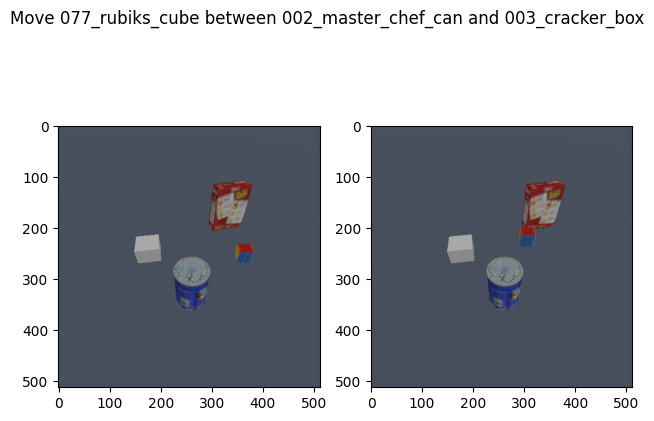

True


In [6]:



fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])

one_obj_directions = ["forward", "backward", "right", "left"]
two_objs_directions = ["front", "behind", "right", "left", "top"]

# single_rand = np.random.choice(np.arange(len(configs)), 1)
# rand = np.random.choice(np.arange(len(configs)), 2, replace=False)

# obj1 = env.unwrapped.objs[rand[0]]
# obj2 = env.unwrapped.objs[rand[1]]
# obj3 = env.unwrapped.objs[single_rand[0]]

# one_obj_direction = np.random.choice(one_obj_directions)
# place_object_in_direction(env, obj1, one_obj_direction, 0.4)

# two_objs_direction = np.random.choice(two_objs_directions)
# place_object_on_another(env, obj2, obj3, two_objs_direction, 0.3)

rand = np.random.choice(np.arange(len(configs)), 3, replace=False)
obj1 = env.unwrapped.objs[rand[0]]
obj2 = env.unwrapped.objs[rand[1]]
obj3 = env.unwrapped.objs[rand[2]]
place_object_in_between(obj1, obj2, obj3)

obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])
# plt.suptitle(f"Move {obj1.name} {one_obj_direction} and {obj2.name} {two_objs_direction} of {obj3.name}")
plt.suptitle(f"Move {obj1.name} between {obj2.name} and {obj3.name}")
plt.tight_layout()
plt.show()

# make sure all objects are present
ids = [obj.id for obj in env.unwrapped.objs]

all_present = np.all(np.isin(ids, np.unique(obs['image']['base_camera']["Segmentation"])))
print(all_present)


2024-03-13 20:44:48,565 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-13 20:44:48.566] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


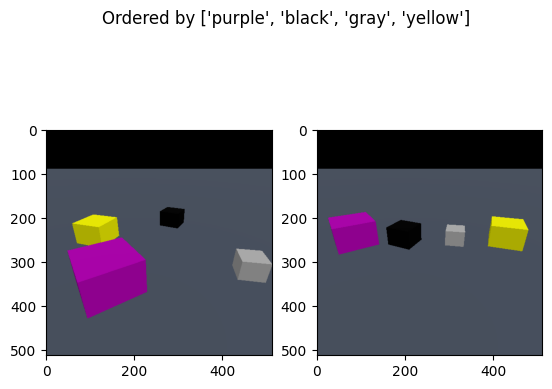

In [231]:
colors = np.random.choice(list(color_maps.keys()), 4, replace=False)
random_scales = np.random.permutation(np.arange(3, 7))

configs= [{
    "name": "cube", 
    "scale": random_scales[i],
    "color": color_maps[colors[i]],
    "color_name": colors[i],
    "static": True,
} for i in range(4)]

env = get_env(configs, {"p": [-1, 0, 0.5], "fov": 1.2})
initialize_positions(configs, min_dist=min_distance)

fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])


order_list = [configs[i]["color_name"] for i in range(len(env.unwrapped.objs))][::-1]
order_by_color(env, order_list, colors)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])
plt.suptitle(f"Ordered by {order_list}")
plt.show()

2024-03-13 20:44:45,732 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-13 20:44:45.733] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_articulations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_articulations` for environment variables or `env.get_wrapper_attr('get_articulations')` that will search the reminding wrappers.
  logger.warn(
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.objs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.objs` for environment variables or `env.get_wrapper_attr('objs')` that will search the reminding wrap

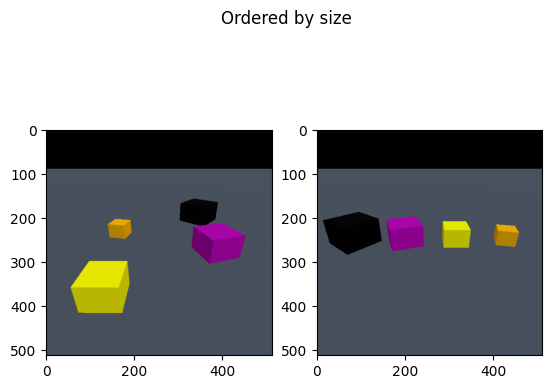

In [230]:
colors = np.random.choice(list(color_maps.keys()), 4, replace=False)
random_scales = np.random.permutation(np.arange(3, 7))
configs= [{
    "name": "cube", 
    "scale": random_scales[i],
    "color": color_maps[colors[i]],
    "color_name": colors[i],
    "static": True,
} for i in range(4)]

env = get_env(configs, {"p": [-1, 0, 0.5], "fov": 1.2})
initialize_positions(configs, min_dist=min_distance)

fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])
order_by_size(env, configs)

obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])
plt.suptitle(f"Ordered by size")
plt.show()

2024-03-13 20:55:44,554 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-03-13 20:55:44.555] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
/home/mkim/miniconda3/envs/mixlab/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_articulations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_articulations` for environment variables or `env.get_wrapper_attr('get_articulations')` that will search the reminding wrappers.
  logger.warn(


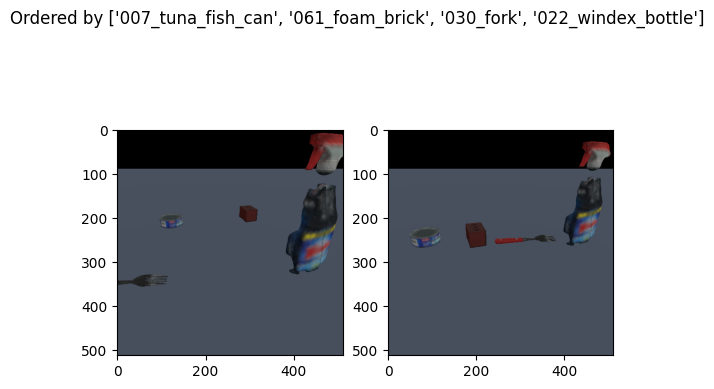

In [264]:
def get_ycb_order_config(model_paths):
    model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))
    configs = [
        {
            "name": model_paths[i],
            "scale": 2,
            "static": True,
        }
        for i in np.random.choice(np.arange(len(model_paths)), 4, replace=False).astype(int)
    ]
    camera_cfgs = {"p": [-1, 0, 0.5], "fov": 1.2}
    return configs, camera_cfgs

configs, camera_cfgs = get_ycb_order_config(model_paths)
env = get_env(configs, camera_cfgs)
initialize_positions(configs, min_dist=min_distance)

fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])

name_list = [c["name"] for c in configs][::-1]
name_list_str = [c.split('/')[-1] for c in name_list]
order_by_name(env, name_list, configs)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])


plt.suptitle(f"Ordered by {name_list_str}")
plt.show()

In [265]:
def get_motion_configs(model_paths):
    configs = [
        {
            "name": model_paths[i],
            "scale": 2,
            "static": False,
        }
        for i in np.random.choice(np.arange(len(model_paths)), 4, replace=False).astype(int)
    ]
    return configs

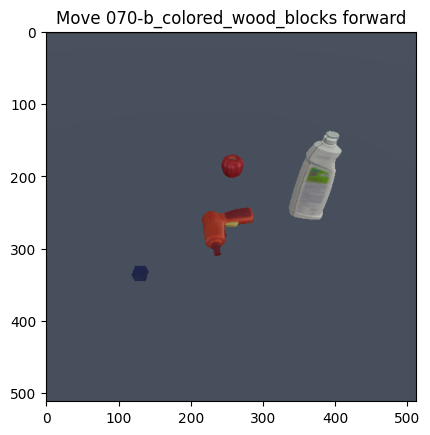

In [266]:
# motion
model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))
configs = get_motion_configs(model_paths)
env = get_env(configs)

initialize_positions(configs, min_dist=min_distance)
random_force = np.random.choice([-250, 250], 3)


random_force = get_random_force()

random_force[2] = 0
motion_map = {
    "forward": np.array([-250, 0, 0]),
    "backward": np.array([250, 0, 0]),
    "right": np.array([0, -250, 0]),
    "left": np.array([0, 250, 0]),
    "random": random_force,
    # "up": np.array([0, 0, 125]), # hard to determine between direction
}


rand_obj = np.random.choice(env.unwrapped.objs)
rand_direction = np.random.choice(list(motion_map.keys()))

[obj.set_velocity(np.array([0, 0, 0])) for obj in env.unwrapped.objs]

# rand_obj = env.objs[0]
# rand_direction = "random"
# rand_direction = "up"


for idx in range(1, 9):  # Simulate for 1 second
    move_object(rand_obj, rand_direction, motion_map, 1/idx)
    # env.obj.add_force_at_point(np.array([0, 0 , 1000]), np.array([0, 0, 0]))
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    clear_output(wait=True)

    plt.imshow(obs['image']['base_camera']['rgb'])
    plt.title(f"Move {rand_obj.name} {rand_direction}")
    plt.show()
    time.sleep(0.1)

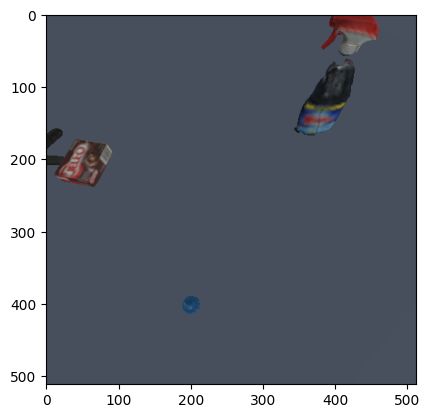

In [89]:
model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))
configs = [
    {
        "name": model_paths[i],
        "scale": 2,
        "static": False,
    }
    for i in np.random.uniform(0, len(model_paths), 4).astype(int)
]


env = get_env(configs)
initialize_positions(configs, min_dist=min_distance)

obj1 = env.unwrapped.objs[0]
obj2 = env.unwrapped.objs[1]

direction = get_object_to_object_direction(obj1, obj2)

for idx in range(1, 9):  # Simulate for 1 second
    move_object_toward_another(obj1, direction, 1/(np.sqrt(idx)))
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    clear_output(wait=True)

    plt.imshow(obs['image']['base_camera']['rgb'])
    plt.show()
    time.sleep(0.1)